# Import

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import daft
from causalgraphicalmodels import CausalGraphicalModel
import logging

BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

def precis(trace, var_names=None):
    s = az.summary(trace, hdi_prob=0.89, round_to=2, var_names=var_names)
    return s[['mean', 'sd', 'hdi_5.5%','hdi_94.5%']]

def scale(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [30]:
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.api as sm
from scipy.special import logsumexp
from patsy import dmatrix

from scipy.special import expit as logistic
from scipy.special import softmax

# Chapter 10

Lecutre 11: https://www.youtube.com/watch?v=-4y4X8ELcEM&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=11&ab_channel=RichardMcElreath



All Credits go to: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_10.ipynb
Whenever I got stuck, I would just copy the solution from here.

## 10.1 Maximum Entropy

### Code 10.1

In [16]:
p = pd.DataFrame()
p = p.assign(A=(0,0,10,0,0), B=(0,1,8,1,0), C=(0,2,6,2,0), D=(1,2,4,2,1), E=(2,2,2,2,2))
p

,A,B,C,D,E
0,0,0,0,1,2
1,0,1,2,2,2
2,10,8,6,4,2
3,0,1,2,2,2
4,0,0,0,1,2


### Code 10.2

In [19]:
p_norm = p / p.sum()
p_norm

,A,B,C,D,E
0,0.0,0.0,0.0,0.1,0.2
1,0.0,0.1,0.2,0.2,0.2
2,1.0,0.8,0.6,0.4,0.2
3,0.0,0.1,0.2,0.2,0.2
4,0.0,0.0,0.0,0.1,0.2


### Code 10.3

In [30]:
vals = []
for col in p_norm.columns:
    vals.append(-sum([0 if q == 0 else q*np.log(q) for q in p_norm[col]]).round(7))
vals

[-0.0, 0.6390319, 0.9502705, 1.4708085, 1.6094379]

# Chapter 11

All Credits go to: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_11.ipynb
Whenever I got stuck, I would just copy the solution from here.

## Binomial Regression

### Code 11.1

In [3]:
url = 'https://raw.githubusercontent.com/rmcelreath/rethinking/f9c16bb7faec8a9883d976a769824b1764d12540/data/chimpanzees.csv'
d = pd.read_csv(url, sep=';')

In [4]:
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


### Code 11.2

In [5]:
d['treatment'] = 1 + d.prosoc_left + 2*d.condition

### Code 11.3

In [6]:
d['treatment'].unique()

array([1, 2, 3, 4])

### Code 11.4 + Code 11.5

In [22]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0, 10)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)
    
    m11_1_trace = pm.sample(10000)
    prior_m11_1 = pm.sample_prior_predictive(samples=10000)
    idata11_1 = az.from_pymc3(prior=prior_m11_1)
    
    
with pm.Model() as m11_1_alt:
    a = pm.Normal('a', 0, 1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)
    
    m11_1_alt_trace = pm.sample(10000)
    prior_m11_1_alt = pm.sample_prior_predictive(samples=10000)
    idata11_1_alt = az.from_pymc3(prior=prior_m11_1_alt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.


### Code 11.6

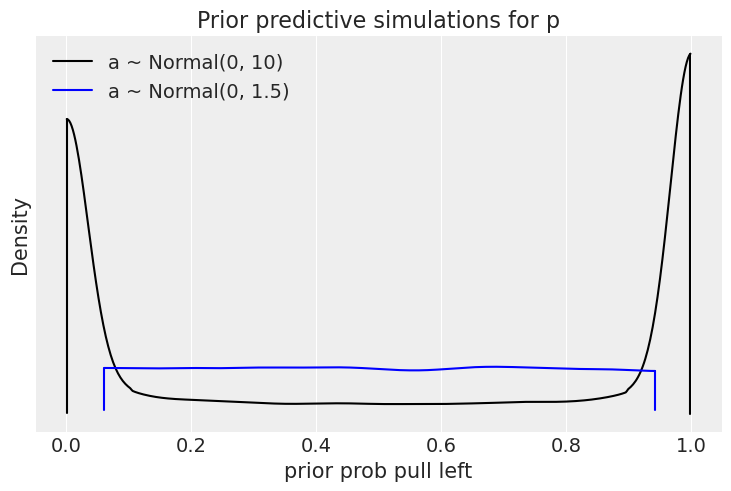

In [24]:
ax = az.plot_density(
    [idata11_1, idata11_1_alt],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)
plt.xlabel("prior prob pull left")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

## Code 11.7 - 11.9

In [35]:
treatment = pd.factorize(d.treatment)

In [66]:
with pm.Model() as m11_2:
    a = pm.Normal('a', 0, 1.5)
    b = pm.Normal('b', 0, 10, shape=treatment[1].size)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[treatment[0]]))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)
    
    prior_11_2 = pm.sample_prior_predictive(samples=10000)
    idata_11_2 = az.from_pymc3(prior=prior_11_2)

prior_11_2 = idata_11_2.prior

with pm.Model() as m11_2_alt:
    a = pm.Normal('a', 0, 1.5)
    b = pm.Normal('b', 0, 0.5, shape=treatment[1].size)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[treatment[0]]))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)
    
    prior_11_2_alt = pm.sample_prior_predictive(samples=10000)
    idata_11_2_alt = az.from_pymc3(prior=prior_11_2_alt)

prior_11_2_alt = idata_11_2_alt.prior

In [67]:
p_treat1, p_treat2 = (
    logistic(prior_11_2["a"] + prior_11_2["b"].sel(b_dim_0=0)),
    logistic(prior_11_2["a"] + prior_11_2["b"].sel(b_dim_0=1)),
)

In [68]:
p_treat1_alt, p_treat2_alt = (
    logistic(prior_11_2_alt["a"] + prior_11_2_alt["b"].sel(b_dim_0=0)),
    logistic(prior_11_2_alt["a"] + prior_11_2_alt["b"].sel(b_dim_0=1)),
)

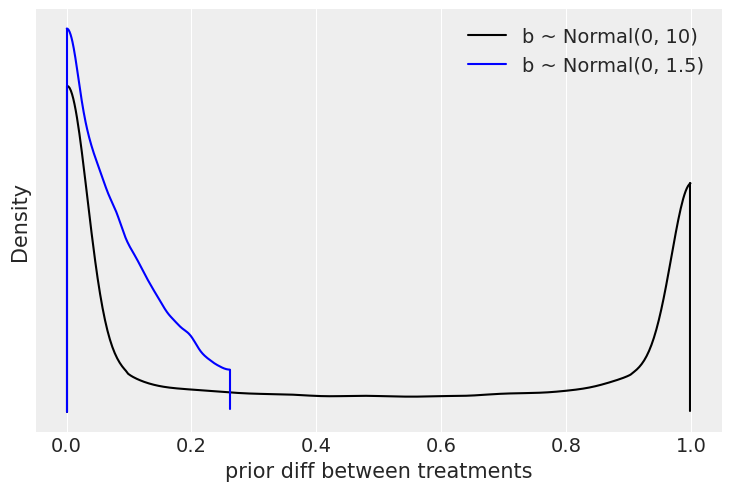

In [69]:
ax = az.plot_density(
    [np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_alt - p_treat2_alt).values],
    data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    point_estimate=None,
)
plt.xlabel("prior diff between treatments")
plt.ylabel("Density")
plt.title(None)
plt.show()